In [7]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import imblearn
from sklearn.preprocessing import LabelEncoder
import fastai
from fastai import *
import fastai.tabular.all

In [8]:
data_file = '../5v_cleandf.rdata'
r_format = pyreadr.read_r(data_file)

In [9]:
r_format.keys()

odict_keys(['df'])

In [10]:
df = r_format['df']
df.head().T

,0,1,2,3,4
dep_name,B,B,B,A,A
esi,4,4,2,2,3
age,40,66,66,66,84
gender,Male,Male,Male,Male,Female
ethnicity,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino,Hispanic or Latino
...,...,...,...,...,...
cc_woundcheck,0,0,0,0,0
cc_woundinfection,0,0,0,0,0
cc_woundre-evaluation,0,0,0,0,0
cc_wristinjury,0,0,0,0,0


In [11]:
for col in df.columns:
    print(col)

dep_name
esi
age
gender
ethnicity
race
lang
religion
maritalstatus
employstatus
insurance_status
disposition
arrivalmode
arrivalmonth
arrivalday
arrivalhour_bin
previousdispo
2ndarymalig
abdomhernia
abdomnlpain
abortcompl
acqfootdef
acrenlfail
acutecvd
acutemi
acutphanm
adjustmentdisorders
adltrespfl
alcoholrelateddisorders
allergy
amniosdx
analrectal
anemia
aneurysm
anxietydisorders
appendicitis
artembolism
asppneumon
asthma
attentiondeficitconductdisruptivebeha
backproblem
biliarydx
birthasphyx
birthtrauma
bladdercncr
blindness
bnignutneo
bonectcncr
bph
brainnscan
breastcancr
breastdx
brnchlngca
bronchitis
burns
cardiaarrst
cardiacanom
carditis
cataract
cervixcancr
chestpain
chfnonhp
chrkidneydisease
coaghemrdx
coloncancer
comabrndmg
complicdevi
complicproc
conduction
contraceptiv
copd
coronathero
crushinjury
cysticfibro
deliriumdementiaamnesticothercognitiv
developmentaldisorders
diabmelnoc
diabmelwcm
disordersusuallydiagnosedininfancych
diverticulos
dizziness
dminpreg
dysrhythmia
e

Potentially relevant columns here are `gender`, `ethnicity`, `race`, `employstatus`, `insurance_status`, `disposition`. The majority of the columns are categorical results of whether a patient has a condition or not.

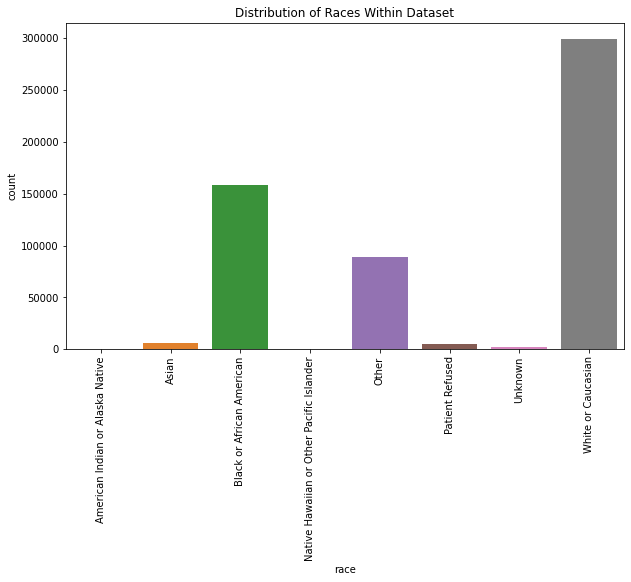

In [12]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(x='race', data=df)
plt.title('Distribution of Races Within Dataset')
plt.xticks(rotation=90)
plt.show()

In [13]:
df['race'].value_counts()

White or Caucasian                           299632
Black or African American                    157884
Other                                         89359
Asian                                          5790
Patient Refused                                5203
Unknown                                        1702
American Indian or Alaska Native                515
Native Hawaiian or Other Pacific Islander       375
Name: race, dtype: int64

# Insurance

In [14]:
def pie_chart(insurance_status, data, data2):
    color_palette = {
        'White or Caucasian': 'blue',
        'Black or African American': 'orange',
        'Other': 'green',
        'Asian': 'red',
        'Patient Refused': 'purple',
        'Unknown': 'brown',
        'American Indian or Alaska Native': 'pink',
        'Native Hawaiian or Other Pacific Islander': 'gray',
        np.nan: 'yellow'
    } # set the color palette so that all plots have the same colors for the same race
    fig = plt.figure(figsize=(15, 15))
    
    def pie_subplot(data, row, col, which, title):
        # get the subsection of the dataframe with that particular insurance status
        data_with_insurance_status = data[data['insurance_status'] == insurance_status]
        unique_races = data_with_insurance_status['race'].unique()

        keys_data = []
        for race in unique_races:
            keys_data.append(
                (
                    race,
                    data_with_insurance_status[data_with_insurance_status['race'] == race]['race']
                        .count()
                ) # append a particular race and the number of people with a particular insurance status
            )

        keys_data.sort(key=lambda x: x[1], reverse=True) # sort by the number of people

        keys = [x[0] for x in keys_data]
        values = [x[1] for x in keys_data]

        colors = [color_palette[x] for x in keys]

        # Plot a pie chart
        plt.subplot(row, col, which)
        plt.pie(values, colors=colors)
        plt.legend(keys)
        plt.title(title)

    # data is a comprised of samples of 100 datapoints for each race because there aren't an
    # equal amount of each race --> this is a way to show the real distribution
    pie_subplot(data, 1, 2, 1, insurance_status)
    # data2 is just the whole dataframe
    pie_subplot(data2, 1, 2, 2, insurance_status + " Real")
    
    plt.show()

In [15]:
def create_sampled_df(df):
    sample1 = df[df['race'] == 'White or Caucasian'].sample(n=100)
    sample2 = df[df['race'] == 'Black or African American'].sample(n=100)
    sample3 = df[df['race'] == 'Other'].sample(n=100)
    sample4 = df[df['race'] == 'Asian'].sample(n=100)
    sample5 = df[df['race'] == 'Patient Refused'].sample(n=100)
    sample6 = df[df['race'] == 'Unknown'].sample(n=100)
    sample7 = df[df['race'] == 'American Indian or Alaska Native'].sample(n=100)
    sample8 = df[df['race'] == 'Native Hawaiian or Other Pacific Islander'].sample(n=100)

    # Put the samples together into one dataframe for use
    plot_df = pd.concat([sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8])
    return plot_df

In [16]:
plot_df = create_sampled_df(df)

## Visualizing Race Distributions of Insurance Types

In [17]:
print(list(df['insurance_status'].unique()))

['Other', 'Commercial', 'Medicare', 'Medicaid', 'Self pay']


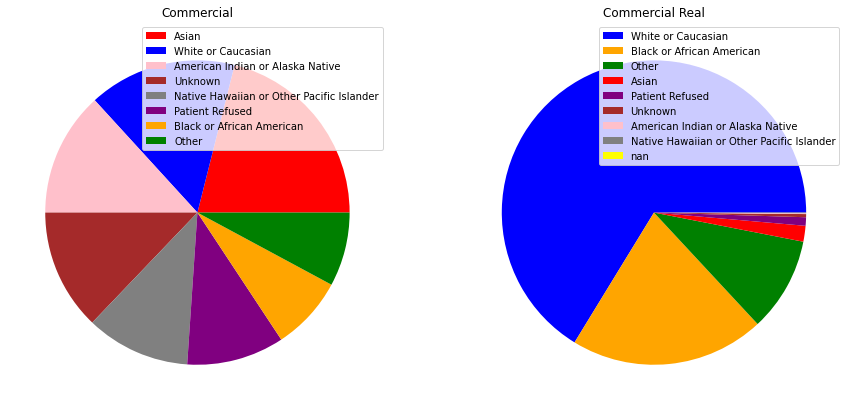

In [18]:
pie_chart('Commercial', plot_df, df)

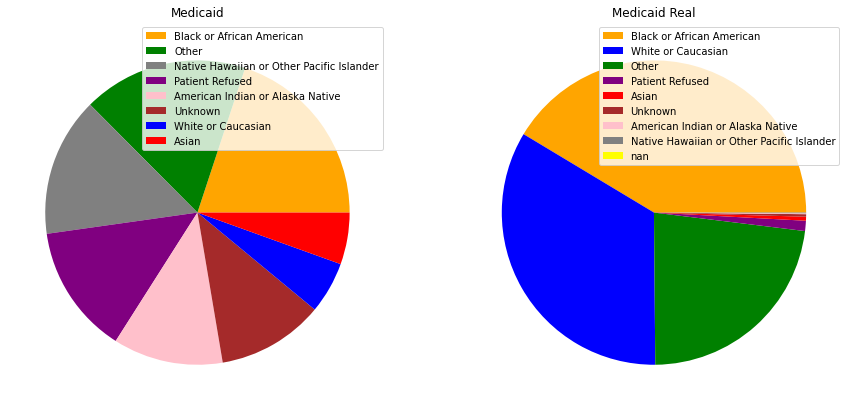

In [19]:
pie_chart('Medicaid', plot_df, df)

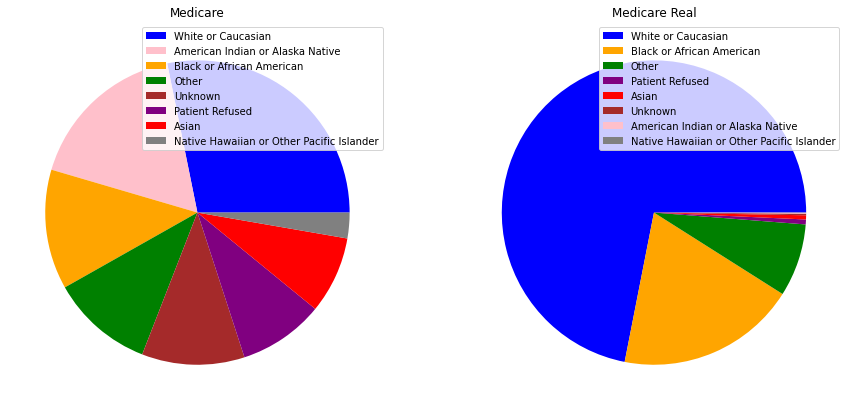

In [20]:
pie_chart('Medicare', plot_df, df)

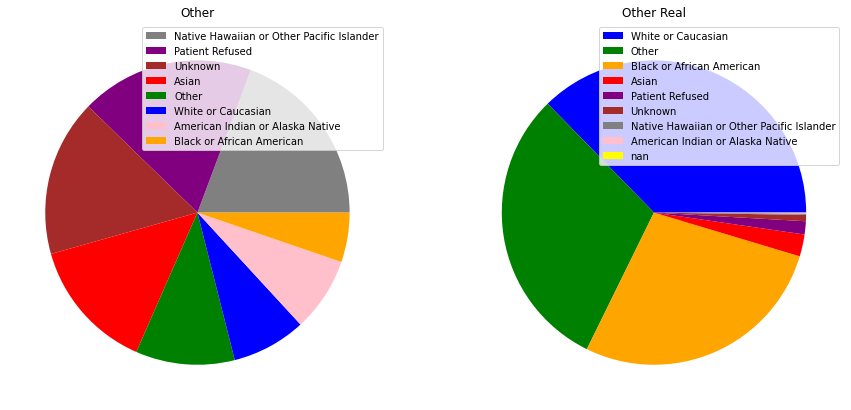

In [21]:
pie_chart('Other', plot_df, df)

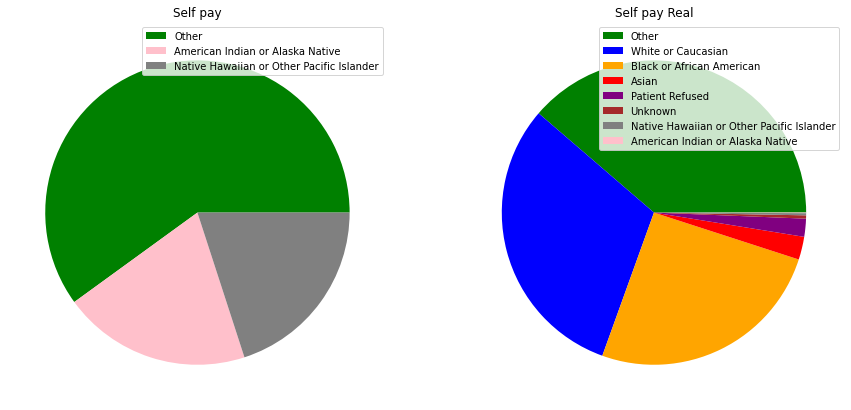

In [22]:
pie_chart('Self pay', plot_df, df)

The only notable thing I noticed was that despite its smaller population, a greater percentage of black people have Medicaid.

# Employment Status

In [23]:
print(list(df['employstatus'].unique()))

['Full Time', 'Not Employed', 'Retired', 'Disabled', 'Part Time', 'Self Employed', 'On Active Military Duty', 'Student - Full Time', 'Unknown', 'Student - Part Time']


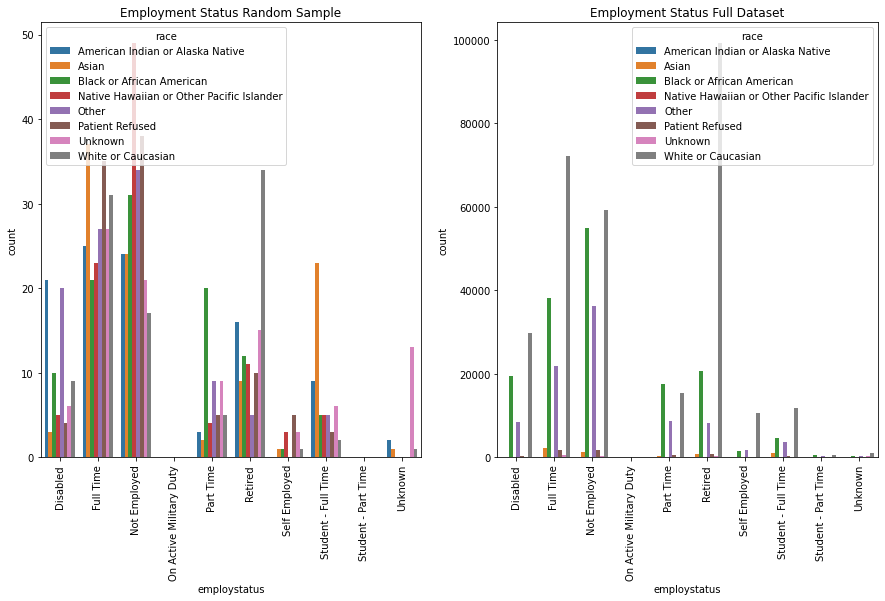

In [24]:
fig = plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='employstatus', data=plot_df, hue='race')
plt.xticks(rotation=90)
plt.title('Employment Status Random Sample')
plt.subplot(1, 2, 2)
sns.countplot(x='employstatus', data=df, hue='race')
plt.xticks(rotation=90)
plt.title('Employment Status Full Dataset')
plt.show()

There are no blatant disparrities within the employment status.

# Disposition

In [25]:
print(list(df['disposition'].unique()))

['Discharge', 'Admit']


In [26]:
print(list(df['previousdispo'].unique()))

['No previous dispo', 'Discharge', 'Admit', 'Transfer to Another Facility', 'AMA', 'LWBS after Triage', 'Eloped', 'LWBS before Triage', 'Observation', 'Send to L&D']


## Heatmap of Race & Disposition on Full Dataframe

In [27]:
def p(contingency):
    c, p_val, dof, expected = chi2_contingency(contingency)
    return p_val

In [28]:
contingency = pd.crosstab(df['race'], df['previousdispo'])
contingency

previousdispo,AMA,Admit,Discharge,Eloped,LWBS after Triage,LWBS before Triage,No previous dispo,Observation,Send to L&D,Transfer to Another Facility
race,,,,,,,,,,
American Indian or Alaska Native,1,106,243,3,6,2,145,0,1,8
Asian,11,644,1805,2,28,0,3089,0,1,210
Black or African American,870,30079,90887,668,2134,405,31153,97,91,1500
Native Hawaiian or Other Pacific Islander,0,40,166,1,5,1,156,0,0,6
Other,372,13351,48078,283,1055,135,25344,49,63,629
Patient Refused,14,678,2395,7,37,10,2014,0,4,44
Unknown,8,170,580,2,11,3,911,0,0,17
White or Caucasian,1252,72808,118076,586,1495,241,101186,180,48,3760


In [29]:
# contingency_pct = pd.crosstab(df['race'], df['previousdispo'], normalize='index')
# contingency_pct

<AxesSubplot:xlabel='previousdispo', ylabel='race'>

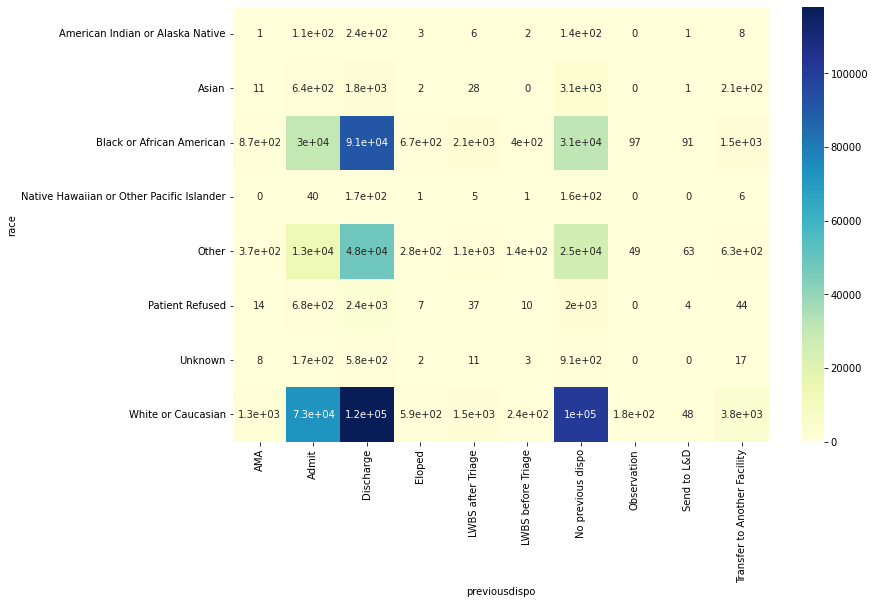

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap='YlGnBu')

* L&D -> Labor And Delivey
* LWBS -> Left Without Being Seen By Physician
* AMA -> Against Medical Service ??
* Eloped -> Eloped During Treatment

In [31]:
p(contingency)
#surface level stat analysis shows a correlation btw ethnicity and disposition within the hospital

0.0

## Heatmap of Race & Disposition on Sampled Dataframe

In [32]:
contingency = pd.crosstab(plot_df['race'], plot_df['previousdispo'])
contingency

previousdispo,AMA,Admit,Discharge,Eloped,LWBS after Triage,LWBS before Triage,No previous dispo,Send to L&D,Transfer to Another Facility
race,,,,,,,,,
American Indian or Alaska Native,0,17,43,0,2,0,36,0,2
Asian,0,9,33,0,0,0,56,0,2
Black or African American,0,23,54,0,7,0,15,0,1
Native Hawaiian or Other Pacific Islander,0,8,44,1,0,0,45,0,2
Other,3,14,55,0,0,0,28,0,0
Patient Refused,0,12,42,0,1,0,44,1,0
Unknown,1,15,36,0,0,0,48,0,0
White or Caucasian,2,18,37,1,0,2,40,0,0


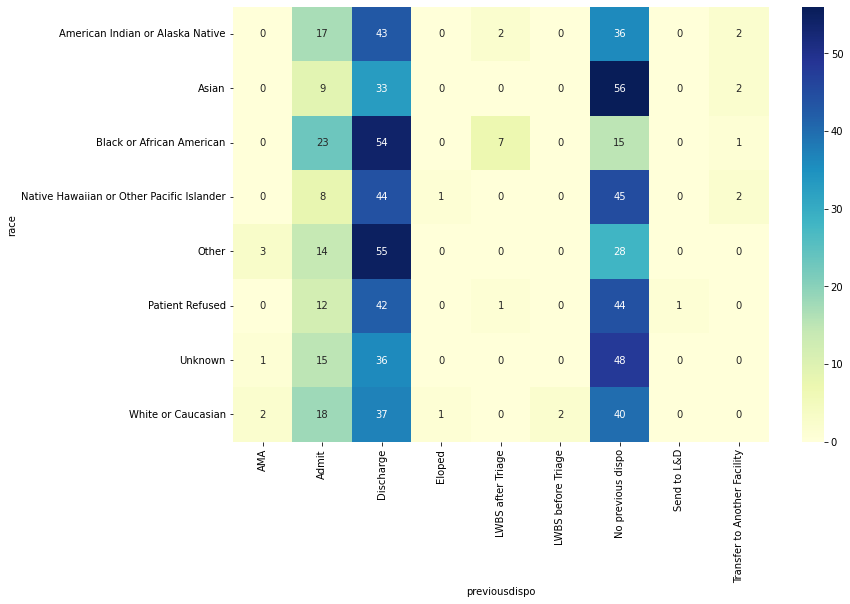

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")
plt.show()

In [34]:
p(contingency)
#surface level stat analysis shows a correlation btw ethnicity and disposition within the hospital

4.271019781858257e-08

## Heatmap of Gender & Disposition

<AxesSubplot:xlabel='previousdispo', ylabel='gender'>

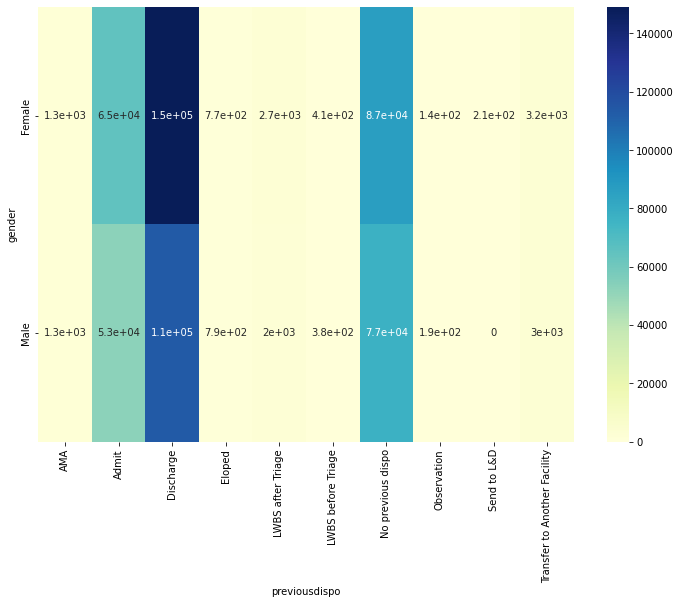

In [35]:
contingency = pd.crosstab(df['gender'], df['previousdispo'])
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")

In [36]:
p(contingency)

5.440742225607243e-192

## Heatmap of Age & Disposition

In [37]:
(df.age.max(), df.age.min())

(108, 18)

In [38]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['(0-10]', '(10-20]', '(20-30]', '(30-40]',
          '(40-50]', '(50-60]', '(60-70]', '(70-80]', '(80-90]', '(90-100]', '(100-110]']

df['age_groups'] = pd.cut(x=df['age'], bins=bins, labels=labels)
df['age_groups']

0         (30-40]
1         (60-70]
2         (60-70]
3         (60-70]
4         (80-90]
           ...   
560481    (40-50]
560482    (40-50]
560483    (40-50]
560484    (40-50]
560485    (40-50]
Name: age_groups, Length: 560486, dtype: category
Categories (11, object): ['(0-10]' < '(10-20]' < '(20-30]' < '(30-40]' ... '(70-80]' < '(80-90]' < '(90-100]' < '(100-110]']

<AxesSubplot:xlabel='previousdispo', ylabel='age_groups'>

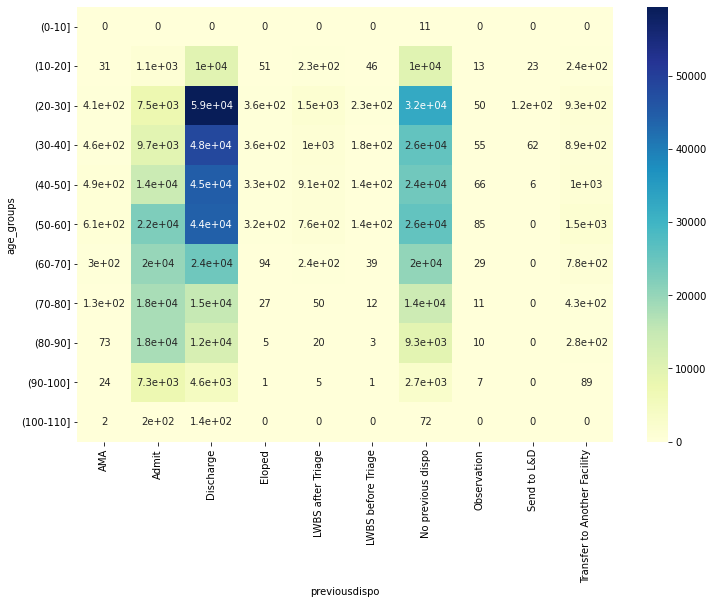

In [39]:
contingency = pd.crosstab(df['age_groups'], df['previousdispo'])
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")

In [40]:
p(contingency)

0.0

## Heatmap of Race & Arrival Mode

<AxesSubplot:xlabel='arrivalmode', ylabel='race'>

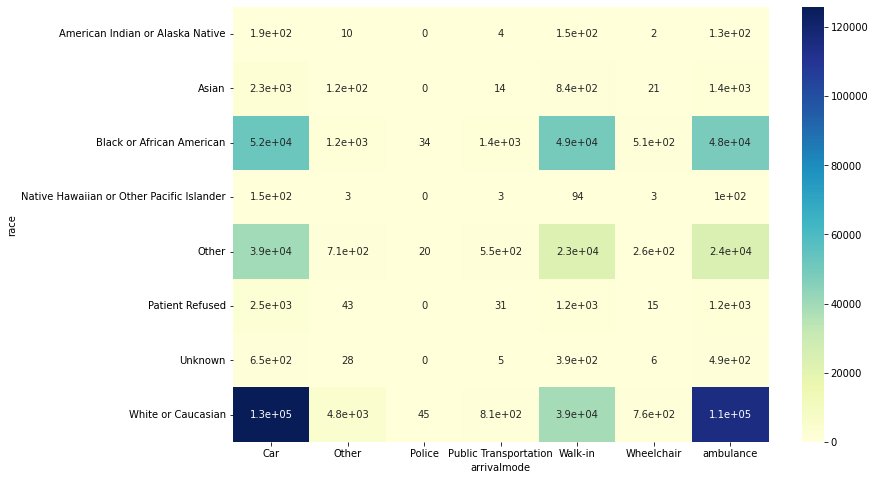

In [41]:
contingency = pd.crosstab(df['race'], df['arrivalmode'])
plt.figure(figsize=(12, 8))
sns.heatmap(contingency, annot=True, cmap="YlGnBu")

In [42]:
p(contingency)

0.0

# Condensing Dataset

Condense the large dataframe into another with only the necessary columns.

The columns of the dataframe have a significant member of **null** values; however, we still have enough data, that removing the rows with any null values will leave us with plenty of data. Therefore, instead of letting the nulls propogate to more refined versions of the dataset, we can remove them right here.

First we create a smaller dataframe with only the columns we care about, in order to condense the data and speed up operation times.

In [43]:
columns = ['esi',
           'age',
           'gender',
           'ethnicity',
           'race',
           'lang',
           'religion',
           'maritalstatus',
           'employstatus',
           'insurance_status',
           'disposition',
           'arrivalmode',
           'previousdispo']

data = df.copy()[columns]

In [44]:
data.shape

(560486, 13)

In [45]:
# Remove the rows with missing values for every column

cols_in_dataframe = list(data.columns)

for col in cols_in_dataframe:
    rows_to_remove = []
    nulled_col = list(data[col].isnull())
    for i in range(len(nulled_col)):
        if nulled_col[i] == True:
            rows_to_remove.append(i)
    rows_to_remove.sort(reverse=True)
    
    data.drop(rows_to_remove, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    print('Done condensing:', col)

Done condensing: esi
Done condensing: age
Done condensing: gender
Done condensing: ethnicity
Done condensing: race
Done condensing: lang
Done condensing: religion
Done condensing: maritalstatus
Done condensing: employstatus
Done condensing: insurance_status
Done condensing: disposition
Done condensing: arrivalmode
Done condensing: previousdispo


In [46]:
data.shape

(537194, 13)

All the rows with a **null** value in them are now removed from the dataframe.

# Creating An Averaged Table

In [47]:
# ( number of samples, contingency variable 1, contingency variable 2, dataframe )
def create_samples(num_samples, contv1, contv2, df):
    samples = []
    for i in range(num_samples):
        plot_df = create_sampled_df(df)
        contingency = pd.crosstab(plot_df[contv1], plot_df[contv2])

        # find the columns that were not in the contingency table
        # all the columns that are left over
        left_over = list(set(df[contv2].unique()) - set(contingency.columns))
        for col in left_over:
            contingency[col] = [0 for _ in list(contingency.index)]

        samples.append(contingency)
    return samples


def create_average_contingency_table(samples):
    samples_len = len(samples)
    main_df = pd.DataFrame()

    shapes = [x.shape for x in samples]
    example_sample = samples[0]

    for col in example_sample:
        values = []
        for sample in samples:
            values.append(np.array(sample[col]))
        values = np.array(values)
        average_values = np.mean(values, axis=0)
        main_df[col] = average_values

    main_df = main_df.set_index(pd.Index(example_sample.index))
    return main_df

In [48]:
samples = create_samples(100, 'race', 'previousdispo', data)

In [49]:
average_cont_table = create_average_contingency_table(samples)
average_cont_table

,AMA,Admit,Discharge,Eloped,LWBS after Triage,LWBS before Triage,No previous dispo,Transfer to Another Facility,Send to L&D,Observation
race,,,,,,,,,,
American Indian or Alaska Native,0.22,21.02,47.49,0.57,1.41,0.41,27.32,1.35,0.21,0.00
Asian,0.23,12.82,27.27,0.07,0.50,0.00,54.51,4.59,0.01,0.00
Black or African American,0.56,18.87,57.29,0.47,1.47,0.29,19.82,1.11,0.08,0.04
Native Hawaiian or Other Pacific Islander,0.00,11.30,42.55,0.30,1.41,0.32,42.43,1.69,0.00,0.00
Other,0.32,15.22,54.06,0.37,1.05,0.24,27.91,0.72,0.08,0.03
Patient Refused,0.26,12.83,46.37,0.16,0.69,0.19,38.58,0.87,0.05,0.00
Unknown,0.55,10.32,33.70,0.04,0.70,0.28,53.38,1.03,0.00,0.00
White or Caucasian,0.37,24.73,38.93,0.33,0.43,0.08,33.71,1.31,0.01,0.10


# Modifying Dataframe

In [50]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(sampling_strategy='minority')

In [51]:
%%capture
cont = ['esi', 'age']
cat = [
    'gender',
    'ethnicity',
    'race',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
    'previousdispo'
]

# Create individual label encoders for each column
transformers = {}
for col in cat:
    transformers[col] = LabelEncoder()

# fit each column with its corresponding label encoder
for col in cat:
    data[col] = data[[col]].apply(transformers[col].fit_transform)

In [52]:
data.head(2)

,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,previousdispo
0,4,40,1,0,7,0,8,7,1,3,1,4,6
1,4,66,1,0,3,0,10,4,2,0,1,0,6


In [53]:
data['esi'] = data['esi'].astype(int)

In [54]:
col_to_balance = 'race'
cols_without_balancing_col = [
    'esi',
    'age',
    'gender',
    'ethnicity',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
    'previousdispo'
]

X, y = data[cols_without_balancing_col].values, data[col_to_balance].values

The resampler resamples the smallest member to the biggest member and this needs to be done a certain number of times to get an equal amount of each race within the dataset.

In [55]:
X_resampled, y_resampled = sampler.fit_resample(X, y)
X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)
X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)
X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)
X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)
X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)
X_resampled, y_resampled = sampler.fit_resample(X_resampled, y_resampled)

Some of the races are extremely small in propertion to other races. The operation above scales all the data from the races with the smallest dataset population to the races with the largest dataset population. This results in a lot of generated or repeated data, which might affect the quality of the models that this data can produce.

In [56]:
from collections import Counter

In [57]:
Counter(y_resampled)

Counter({7: 285494,
         3: 285494,
         4: 285494,
         2: 285494,
         5: 285494,
         1: 285494,
         6: 285494,
         0: 285494})

Above is now the number of samples for each race where the numbers `[0-7]` can be corresponded to a label encoded race. The race can be derived with `transformers['race'].inverse_transform([0, 1, 2, 3, 4, 5, 7, 7])`.

In [58]:
X_resampled.shape

(2283952, 12)

In [59]:
full = pd.DataFrame(X_resampled, columns=cols_without_balancing_col)

In [60]:
full.head()

,esi,age,gender,ethnicity,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,previousdispo
0,4,40,1,0,0,8,7,1,3,1,4,6
1,4,66,1,0,0,10,4,2,0,1,0,6
2,2,66,1,0,0,10,4,2,0,1,4,2
3,2,66,1,0,0,10,4,2,0,1,0,2
4,3,84,0,0,1,10,9,5,2,0,4,2


In [61]:
full['race'] = y_resampled
full.head()

,esi,age,gender,ethnicity,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,previousdispo,race
0,4,40,1,0,0,8,7,1,3,1,4,6,7
1,4,66,1,0,0,10,4,2,0,1,0,6,3
2,2,66,1,0,0,10,4,2,0,1,4,2,3
3,2,66,1,0,0,10,4,2,0,1,0,2,3
4,3,84,0,0,1,10,9,5,2,0,4,2,4


In [62]:
full.columns

Index(['esi', 'age', 'gender', 'ethnicity', 'lang', 'religion',
       'maritalstatus', 'employstatus', 'insurance_status', 'disposition',
       'arrivalmode', 'previousdispo', 'race'],
      dtype='object')

In [63]:
procedures = []
splits = fastai.tabular.all.RandomSplitter(
    valid_pct=0.2, seed=42)(fastai.tabular.all.range_of(full))

cont = ['esi', 'age']
cat = [
    'gender',
    'ethnicity',
    'race',
    'lang',
    'religion',
    'maritalstatus',
    'employstatus',
    'insurance_status',
    'disposition',
    'arrivalmode',
]

Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)


RuntimeError: Numpy is not available

`cat` and `cont` are the *categorical* and the *continuous* variables.

In [ ]:
to = fastai.tabular.all.TabularPandas(
    df=full,
    procs=procedures,
    cat_names=cat,
    cont_names=cont,
    y_names='previousdispo',
    splits=splits
)
to.show(5)

In [ ]:
X_train, y_train = to.train.xs, to.train.y
X_test, y_test = to.valid.xs, to.valid.y

# Random Forest (300)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(300, verbose=2, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Decision Tree

It has a hard time predicting `LWBS before Triage` and `Observation`.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
model = tree.DecisionTreeClassifier(max_depth= 5000)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [ ]:
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

# Random Forest (500)

It has a hard time predicting `LWBS before Triage` and `Observation`.

In [ ]:
model = RandomForestClassifier(500, verbose=2, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Random Forest (800)

The results are less than encouraging.

In [5]:
X_train.shape

NameError: name 'X_train' is not defined

Divisors of `1827162` are `1, 2, 3, 6, 9, 18, 83, 166, 249, 498, 747, 1223, 1494, 2446, 3669, 7338, 11007, 22014, 101509, 203018, 304527, 609054, 913581, 1827162`. [Divisors Calculator](https://www.hackmath.net/en/calculator/divisors?n=1827162&submit=Calculate)

In [ ]:
batch_size = 1494

X_train_batches = [X_train[x : x + batch_size] for x in range(0, len(X_train), batch_size)]
y_train_batches = [y_train[x : x + batch_size] for x in range(0, len(y_train), batch_size)]

X_train_batches = np.array(X_train_batches)
y_train_batches = np.array(y_train_batches)

In [ ]:
X_train_batches.shape, y_train_batches.shape

In [ ]:
model = RandomForestClassifier(800, n_jobs=-1)
batched_data = list(zip(X_train_batches, y_train_batches))

counter = 1
for i, j in batched_data:
    model.fit(i, j)
    print(f'Done with batch {counter} of {len(batched_data)}')
    counter += 1

In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, preds, average = None)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

plot_labels = list(full['previousdispo'].unique())
plot_labels.sort()
plot_labels_transformed = transformers['previousdispo'].inverse_transform(plot_labels)
class_names = list(plot_labels_transformed)
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Conclusions

A potential problem with the current state of this notebook is that the validation data is also repeated, or generated by the oversampling algorithm, which might be a problem for determining the accuracy.  

In addition, many of the models have a hard time predicting `LWBS before Triage` and `Observation`.

#### Agenda
1. Attempt incorporating Shap Values so we can see the specific datapoints that influence disposition of patient the most
2. Find other way to balance the data that won't lead to lots of repeated data.
Last Priority:
3. Attempt incorporating PCA - dimensionality-reducing model to identify important columns
4. Use other machine learning techniques

# Shap Values implmentation

#### Purpose:
To increase overall model transparency and pinpoint specific metrics that have the largest weight on classification output

In [3]:
import xgboost as xgb
import shap

In [5]:
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X_test, y_test)

NameError: name 'X_test' is not defined

#### 'X_test', 'y_test' used to save time with modeling

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [ ]:
#first plot comparing importance of different metrics
shap.plots.waterfall(shap_values[0])

# Neural Network for Classification using Tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
tf.random.set_seed(42)

In [ ]:
class_model = tf.keras.Sequential([tf.keras.layers.Dense(1)])

In [ ]:
class_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.SGD(), metrics = ['accuracy'])
class_model.fit(X_train, y_train, epochs = 10000)

In [ ]:
class_model.evaluate(X, y)